In [1]:
%matplotlib inline
from cox import readers
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()

In [2]:
r = readers.CollectionReader('../src/kl_coeff_more/agents')

100%|██████████| 80/80 [00:10<00:00,  7.50it/s]


In [4]:
metadata = r.df('metadata')
opt = r.df('optimization')
opt['opt_step'] = opt.index
#nadv = r.df('normalized_advantage')
#nadv['opt_step'] = (nadv.index % 50) * 10
constraints = r.df('paper_constraints_train')
constraints_heldout = r.df('paper_constraints_heldout')

In [5]:
games = ["Walker2d-v2", "Humanoid-v2", "Swimmer-v2", "Hopper-v2",
         "HalfCheetah-v2", "InvertedPendulum-v2", "Reacher-v2",
         "InvertedDoublePendulum-v2"]
code_level_opts = {
      "kl_penalty_direction": ["new_to_old"],
      #'clip_advantages': [1e8],
      #'norm_rewards': ['none', 'returns'],
      #'anneal_lr': [False, True],
      #'value_clipping': [False, True],
      #'initialization': ['xavier', 'orthogonal']
}

NUM_BINS = 20

In [6]:
key_metadata = metadata[['exp_id', 'game'] + list(code_level_opts.keys())]
constraints = constraints.merge(key_metadata, on='exp_id')
constraints_heldout = constraints_heldout.merge(key_metadata, on='exp_id')
#nadv = nadv.merge(key_metadata, on='exp_id')
opt = opt.merge(key_metadata, on='exp_id')

In [7]:
def filter_opts(df, **kwargs):
    for k, v in kwargs.items():
        df = df[df[k] == v]
    return df

# Plot mean rewards

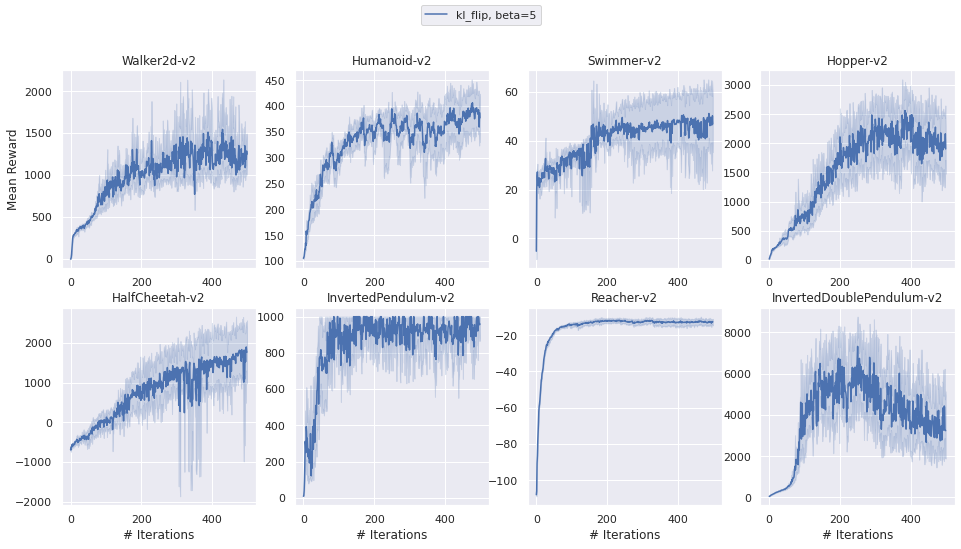

In [8]:
# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
        filt = filter_opts(opt, game=g)
        sns.lineplot(filt.opt_step, filt.mean_reward, n_boot=100,
                     ax=ax.flatten()[j], label='kl_flip, beta=5', legend=False)
        ax.flatten()[j].set_title(g)
        
for a in ax.flatten():
    a.set_ylabel('')
    a.set_xlabel('')
ax[0][0].set_ylabel('Mean Reward')
ax[1][0].set_xlabel('Mean Reward')
for a in ax[1]:
    a.set_xlabel('# Iterations')
    
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2)

plt.show()

In [53]:
filt = filter_opts(constraints_heldout, ppo_lr_adam=3e-4, sign_advantages=False, clip=True, kl_penalty=False)

In [54]:
filt.head()

,avg_kl_old_to_new,avg_kl_new_to_old,avg_ratio,avg_rat_minus_one_sq,max_ratio,opt_step,exp_id,game,clip,kl_penalty,ppo_lr_adam,sign_advantages
50,0.014286,0.014123,1.002568,0.029965,2.080559,0,7ff5ee99-ff01-413a-a021-071435624549,Walker2d-v2,True,False,0.0003,False
51,0.011570,0.011520,0.997578,0.024201,2.057647,10,7ff5ee99-ff01-413a-a021-071435624549,Walker2d-v2,True,False,0.0003,False
52,0.009998,0.009852,0.999511,0.019199,1.917814,20,7ff5ee99-ff01-413a-a021-071435624549,Walker2d-v2,True,False,0.0003,False
53,0.012904,0.012677,1.001194,0.025534,1.879576,30,7ff5ee99-ff01-413a-a021-071435624549,Walker2d-v2,True,False,0.0003,False
54,0.011257,0.011084,0.999569,0.022190,1.837460,40,7ff5ee99-ff01-413a-a021-071435624549,Walker2d-v2,True,False,0.0003,False


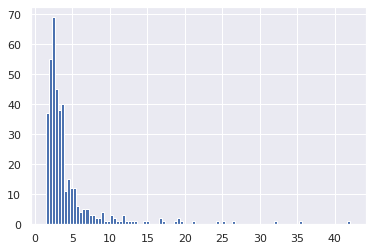

In [57]:
plt.hist(filt.max_ratio, bins=100)
plt.show()

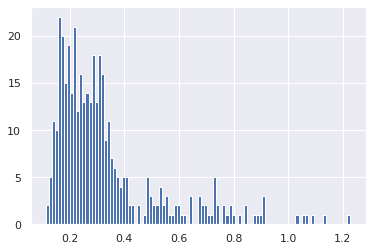

In [59]:
plt.hist(np.sqrt(filt.avg_rat_minus_one_sq), bins=100)
plt.show()

In [81]:
filt = filter_opts(constraints_heldout, ppo_lr_adam=3e-4, sign_advantages=False,
                   clip=False, kl_penalty=True, kl_penalty_direction='old_to_new')

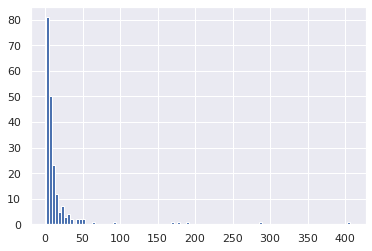

In [82]:
plt.hist(filt.max_ratio, bins=100)
plt.show()

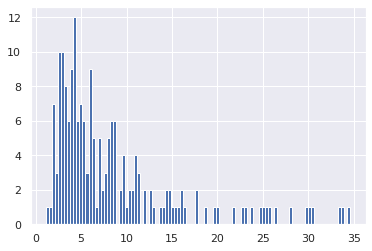

In [83]:
plt.hist(filt[filt.max_ratio < 40].max_ratio, bins=100)
plt.show()

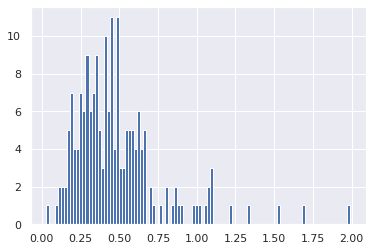

In [84]:
plt.hist(np.sqrt(filt[filt.max_ratio < 40].avg_rat_minus_one_sq), bins=100)
plt.show()

In [75]:
filt = filter_opts(constraints_heldout, ppo_lr_adam=3e-4, sign_advantages=False,
                   clip=False, kl_penalty=True, kl_penalty_direction='new_to_old')

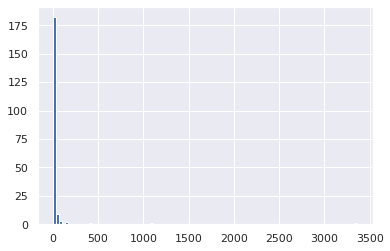

In [76]:
plt.hist(filt.max_ratio, bins=100)
plt.show()

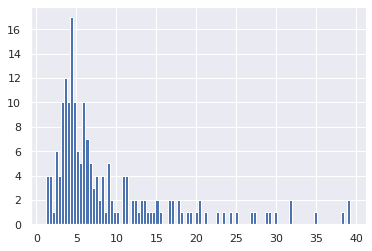

In [77]:
plt.hist(filt[filt.max_ratio < 40].max_ratio, bins=100)
plt.show()

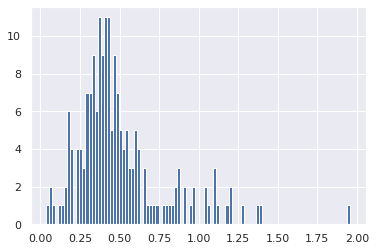

In [78]:
plt.hist(np.sqrt(filt[filt.max_ratio < 40].avg_rat_minus_one_sq), bins=100)
plt.show()

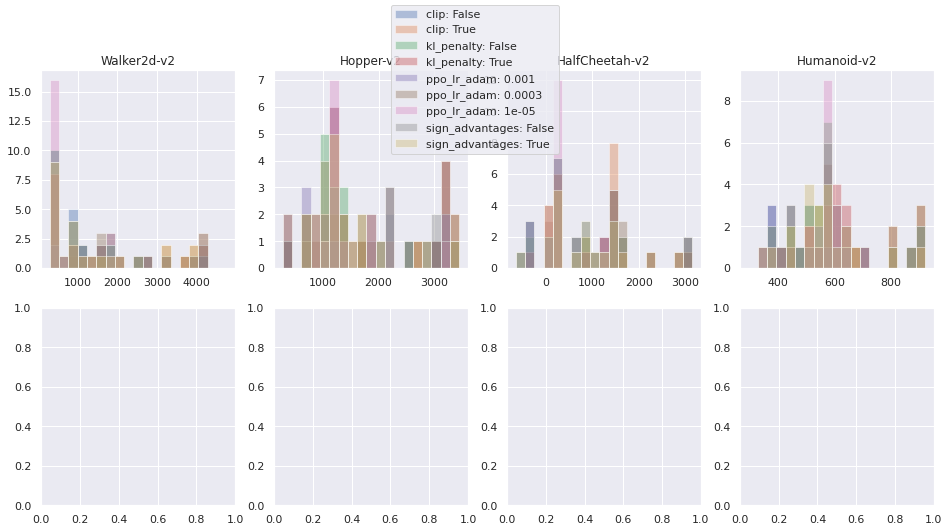

In [26]:
max_rewards = opt.groupby(['exp_id', 'game'] + list(code_level_opts.keys())).max()
max_rewards = max_rewards.reset_index()

# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    # Histogram setup
    _, bin_edges = np.histogram(max_rewards[max_rewards.game == g][
        'mean_reward'].tolist(), NUM_BINS)
    bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_ws = (bin_edges[1] - bin_edges[0])
    kwargs = {'width': bin_ws, 'alpha': 0.65}
    
    for i, cl_opt in enumerate(code_level_opts):
        for ib, b in enumerate(code_level_opts[cl_opt]):
            filt = max_rewards[(max_rewards[cl_opt] == b) & (max_rewards.game == g)]
            #hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
            #hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
            sns.distplot(filt['mean_reward'].tolist(),
                         bins=bin_locs, label=f"{cl_opt}: {b}", ax=ax.flatten()[j], kde=False)
        ax.flatten()[j].set_title(g)
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

# Aggregate performance in normalized scores

In [27]:
max_and_min = max_rewards[['game', 'mean_reward']].groupby('game').max().rename(
    columns={'mean_reward': 'max_max_reward'})
max_and_min['min_max_reward'] = max_rewards[['game', 'mean_reward']].groupby('game').min()

In [28]:
ks = ['game'] + list(code_level_opts.keys())
grouped = max_rewards[ks + ['mean_reward']].groupby(ks).mean().reset_index().set_index(ks)
grouped = grouped.rename(columns={'mean_reward': 'mean_max_reward'})
grouped['stddev'] = max_rewards[ks + ['mean_reward']].groupby(ks).var().reset_index().set_index(ks).apply(np.sqrt)
grouped = grouped.reset_index()
grouped = grouped.reset_index().merge(max_and_min, on='game')
grouped = grouped.set_index(ks)
grouped['normalized_score'] = (grouped['mean_max_reward'] - grouped['min_max_reward']) / (
    grouped['max_max_reward'] - grouped['min_max_reward'])
grouped['normalized_stddev'] = grouped['stddev'] / (
    grouped['max_max_reward'] - grouped['min_max_reward'])
grouped = grouped.dropna()
grouped

index  \
game           clip  kl_penalty ppo_lr_adam sign_advantages          
HalfCheetah-v2 False False      0.00001     False                0   
                                            True                 1   
                                0.00030     False                2   
                                            True                 3   
                                0.00100     False                4   
...                                                            ...   
Walker2d-v2    True  True       0.00001     True                91   
                                0.00030     False               92   
                                            True                93   
                                0.00100     False               94   
                                            True                95   

                                                             mean_max_reward  \
game           clip  kl_penalty ppo_lr_adam sign_advantages                    
HalfCheetah-v2 False False      0.00001     False                 227.855136   
                                            True                  195.888717   
                                0.00030     False                2357.557118   
                                            True                  792.852366   
                                0.00100     False                -429.825836   
...                                                                      ...   
Walker2d-v2    True  True       0.00001     True                  414.088843   
                                0.00030     False                4481.764320   
                                            True                 2633.627632   
                                0.00100     False                2974.598133   
                                            True                 3554.140936   

                                                                  stddev  \
game           clip  kl_penalty ppo_lr_adam sign_advantages                
HalfCheetah-v2 False False      0.00001     False              10.183946   
                                            True               44.150226   
                                0.00030     False            1119.987693   
                                            True               36.897182   
                                0.00100     False               3.159637   
...                                                                  ...   
Walker2d-v2    True  True       0.00001     True                5.166492   
                                0.00030     False             539.334918   
                                            True             1412.717789   
                                0.00100     False            1575.946527   
                                            True              431.397740   

                                                             max_max_reward  \
game           clip  kl_penalty ppo_lr_adam sign_advantages                   
HalfCheetah-v2 False False      0.00001     False               3253.085733   
                                            True                3253.085733   
                                0.00030     False               3253.085733   
                                            True                3253.085733   
                                0.00100     False               3253.085733   
...                                                                     ...   
Walker2d-v2    True  True       0.00001     True                4863.131698   
                                0.00030     False               4863.131698   
                                            True                4863.131698   
                                0.00100     False               4863.131698   
                                            True                4863.131698   

                                                             min_max_reward  \
game         

In [43]:
filter_opts(grouped.reset_index(), ppo_lr_adam=3e-4, sign_advantages=False)

,game,clip,kl_penalty,ppo_lr_adam,sign_advantages,index,mean_max_reward,stddev,max_max_reward,min_max_reward,normalized_score,normalized_stddev
2,HalfCheetah-v2,False,False,0.0003,False,2,2357.557118,1119.987693,3253.085733,-748.608531,0.776213,0.279878
8,HalfCheetah-v2,False,True,0.0003,False,8,3160.587861,130.811746,3253.085733,-748.608531,0.976885,0.032689
14,HalfCheetah-v2,True,False,0.0003,False,14,1554.914724,150.110636,3253.085733,-748.608531,0.575637,0.037512
20,HalfCheetah-v2,True,True,0.0003,False,20,1482.646329,25.598382,3253.085733,-748.608531,0.557578,0.006397
26,Hopper-v2,False,False,0.0003,False,26,2001.441875,861.197042,3529.594634,201.381579,0.540849,0.258757
32,Hopper-v2,False,True,0.0003,False,32,3300.261968,324.325366,3529.594634,201.381579,0.931094,0.097447
38,Hopper-v2,True,False,0.0003,False,38,2013.452536,1817.887965,3529.594634,201.381579,0.544458,0.546205
44,Hopper-v2,True,True,0.0003,False,44,1810.582922,2005.876859,3529.594634,201.381579,0.483503,0.602689
50,Humanoid-v2,False,False,0.0003,False,50,463.244582,9.841052,936.059183,279.950773,0.279365,0.014999
56,Humanoid-v2,False,True,0.0003,False,56,481.370275,80.966483,936.059183,279.950773,0.306991,0.123404
